# Sign Language Translator

La idea de este proyecto reside en crear un modelo de Deep Learning el cual sea capaz de clasificar correctamente las diferentes letras del abecedario de signos (el abecedario americano). Para ello usaremos diferentes técnicas vistas en las clases de la asignautra de Análisis de Datos No Estructurados donde comenzaremos con una CNN creada desde cero por nosotros a técnicas más sofisticadas como puede ser el transfer learning (usaremos redes como la VGG16) y por último comprobaremos como se comporta el modelo si aplicamos data augmentation. A su vez también haremos diversas pruebas en torno a la cantidad de categorias a clasificar para conocer como afecta este parámetro a la hora de clasificar.

## 0. Librerias 

Lo primero de todo será importar todas las librerias que necesitaremos para trabajar, nuestra libreria base para todo esto será keras que se encuentra dentro de tensorflow. También usaremos otras librerias como cv2 para y shutil.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, preprocessing, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, Xception
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import shutil

En caso de trabajar o visualizar el proyecto en Google Colab se deberán ejecutar las siguiente lineas de código para poder conectar Colab con Drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
!ls "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Lenguaje de Signos/Code"

Code  Data_Bi


En caso de no estar instalado instalamos tensorboardcolab.

In [ ]:
!pip install -q tensorboardcolab

A continuación hacemos una comprobación para ver las características de la máquina que tenemos

In [3]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:        10089332 kB
MemAvailable:   12088044 kB
Buffers:          112252 kB
Cached:          1999752 kB
SwapCached:            0 kB
Active:          1363164 kB
Inactive:        1610732 kB
Active(anon):     777076 kB
Inactive(anon):      472 kB
Active(file):     586088 kB
Inactive(file):  1610260 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               208 kB
Writeback:             0 kB
AnonPages:        862028 kB
Mapped:           513868 kB
Shmem:              1196 kB
KReclaimable:      87680 kB
Slab:             136436 kB
SReclaimable:      87680 kB
SUnreclaim:        48756 kB
KernelStack:        6144 kB
PageTables:        12360 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    3913776 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       46132 kB
VmallocChunk:          0 kB
Percpu:          

Para terminar con la parte de Colab lo que hacemos es comprobar la GPU que nos ha sido asignada. En caso de no ser suficiente o estar compartida, se puede reiniciar las veces necesarias hasta conseguir una GPU que nos guste.

In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

Wed Apr 20 16:30:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Importamos los datos

Para este proyecto trabajaremos con 1788 imagenes las cuales estarán divididas en 24 clases (ya que algunas letras no aparecen) teniendo en cada categoria entre 65 y 90 imagenes. A su vez para desarrollar el modelo tendremos que distinguir entre un conjunto de train y de test, para nuestro caso trabajaremos con un 80%-20% el cual ya estará separado de antemano por lo que simplemente habrá que cargar los datos de forma separada como train y test.
Los datos a su vez están dividos en diferentes carpetas que nos facilitan su etiquetado, ya que cada carpeta es una clase diferente.
Esta estructura se repite tanto en train como en test

El primer paso antes de cargar los datos es establecer una serie de caracteristicas / una configuración para los datos que carguemos, donde reescalamos los datos para normalizarlos.

In [ ]:
gen = ImageDataGenerator(rescale=1/255)

Ahora cargamos los datos usando flow_from_directory() para que sea capaz de detectar las diferentes categorias de las imagenes en cada uno de los diferentes directorios.

In [ ]:
train = gen.flow_from_directory('../Data/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test = gen.flow_from_directory('../Data/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

FileNotFoundError: ignored

Ahora con los datos divididos entre train y test ya podemos empezar a desarrollar el primer modelo.

## 2. Primer modelo

En este primer modelo lo que haremos será una red convolucional sencilla en donde nos ajustaremos en el número de parametros a lo preestablecido, es decir, a un x10 de parámetros respecto del total de las imagenes.

Por tanto, nuestra red convolucional tendrá la siguiente estructura:

    1. Capa Convolucional de 8 filtros de 4x4 con función de activación ReLu (stride = 1 y padding = 0)
    
    2. Max Pooling de 5x5
    
    3. Capa Convolucional de 8 filtros de 4x4 con función de activación ReLu (stride = 1 y padding = 0)
    
    4. Max Pooling de 5x5
    
    5. Flatten Layer
    
    6. Capa Densa con 6 neuronas y función de activación ReLu
    
    7. Capa de Salida con activación softmax (al ser multicategorica)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8,(4,4),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Conv2D(8,(4,4),activation='relu'))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

A continuación mostraremos la arquitectura comentada anteriormente con el número de parámetros de cada paso asi como también el tamaño de los outputs.

In [ ]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 477, 717, 8)       392       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 95, 143, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 92, 140, 8)        1032      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 18, 28, 8)        0         
 g2D)                                                            
                                                                 
 flatten_19 (Flatten)        (None, 4032)              0         
                                                                 
 dense_38 (Dense)            (None, 6)               

Ahora lo que haremos será entrenar el modelo con los datos que tenemos, donde usaremos 10 epochs y un tamaño de batch de 16. Como optimizador usaremos un Adam y como métrica usaremos el accuracy. A su vez, usaremos un conjunto de validación que sera el test que hemos sacado antes.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_final = model.fit(train, epochs = 10,batch_size = 16,validation_data=test)

Epoch 1/10
45/45 [==============================] - 114s 2s/step - loss: 3.1842 - accuracy: 0.0817 - val_loss: 3.1747 - val_accuracy: 0.0842
Epoch 2/10
45/45 [==============================] - 105s 2s/step - loss: 3.1731 - accuracy: 0.0873 - val_loss: 3.1716 - val_accuracy: 0.0842
Epoch 3/10
45/45 [==============================] - 119s 3s/step - loss: 3.1698 - accuracy: 0.0873 - val_loss: 3.1687 - val_accuracy: 0.0842
Epoch 4/10
45/45 [==============================] - 110s 2s/step - loss: 3.1669 - accuracy: 0.0873 - val_loss: 3.1660 - val_accuracy: 0.0842
Epoch 5/10
45/45 [==============================] - 107s 2s/step - loss: 3.1640 - accuracy: 0.0873 - val_loss: 3.1634 - val_accuracy: 0.0842
Epoch 6/10
45/45 [==============================] - 112s 2s/step - loss: 3.1613 - accuracy: 0.0873 - val_loss: 3.1610 - val_accuracy: 0.0842
Epoch 7/10
45/45 [==============================] - 109s 2s/step - loss: 3.1589 - accuracy: 0.0873 - val_loss: 3.1589 - val_accuracy: 0.0842
Epoch 8/10
45

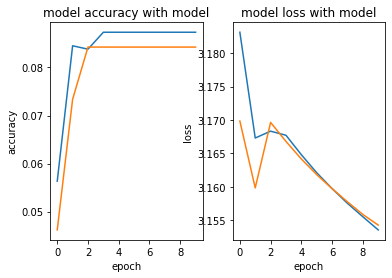

In [ ]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Como se puede observar en la gráfica superior el modelo tiene un accuracy en torno a un 8%-9%, es decir, de cada 10 imagenes solamente clasificará correctamente 1. Esto puede tener diversas causas, desde nuestro punto de vista esto ocurre por dos motivos:

    - Número de Categorias: En este problema nos encontramos ante 24 categorias posibles, por lo que al modelo  le puede costar bastante ser capaz de diferenciar entre una y otra.
    
    - Cantidad de datos: La cantidad de datos que poseemos es muy escasa, por este motivo el modelo le costará  mucho más y además no será capaz de aprender tan bien como si tuviese 10 o 100 veces más de imagenes.
    
Por tanto, la combinación del número de categorias y la cantidad de datos es un fuerte problema para nuestro modelo ya que al tener tantas categorias y tan pocos datos este será capaz de aprender algunas features de cada categoria, pero las cuales pueden ser comunes a otras categorias, por lo que finalmente tendrá que decidir tomando una decisión al azar.

Por última cabe destacar que en la gráfica no observamos que se produzca overfitting, por lo que para un primer modelo con pocos datos y 24 posibles categorias vamos por un buen camino.

## 3. VGG16

La segunda técnica que usaremos para intentar mejorar el accuracy de nuestro primer modelo será la técnica del transfer learning. Para ello usaremos una red ya pre-entrenada que será la VGG16, a la cual no descongelaremos ninguna capa debido a su alto coste computacional y la posibilidad de generar overfitting.

In [ ]:
VGG16_model = VGG16(input_shape = (480, 720, 3),
                    include_top = False, weights = 'imagenet')
VGG16_model.summary()

58900480/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 480, 720, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 480, 720, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 480, 720, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 240, 360, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 240, 360, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 240, 360, 128)     147584    
                                                              

Como hemos comentado al principio, congelamos las capas de base convolucional con el fin de evitar que sus pesos sean actualizadosdurante el entrenamiento.

In [ ]:
for i in VGG16_model.layers:
    layers.trainable = False

Ahora añadimos al modelo dos nuevas capas densas. La última de ellas solo tiene 24 posibles salidas, lo que nos permitirá clasificar las imágenes en las 24 categorías existentes

In [ ]:
tfVGG16_model = keras.Sequential([
    VGG16_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(24, activation = 'softmax'),
])
tfVGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 15, 22, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 168960)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                10813504  
                                                                 
 dense_3 (Dense)             (None, 24)                1560      
                                                                 
Total params: 25,529,752
Trainable params: 25,529,752
Non-trainable params: 0
_________________________________________________________________


Al igual que en el primer modelo usaremos como optimizador Adam y como métrica el accuracy. La diferencia que si meteremos será que añadiremos el early stopping con la finalidad de que pare de entrenar si se produce alguna de la situaciones indicadas.

In [ ]:
tfVGG16_model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=2, 
    restore_best_weights=True,
)

In [ ]:
history_final = tfVGG16_model.fit(train, epochs = 15,batch_size = 16,callbacks=[early_stopping],
                         validation_data=test)

Epoch 1/15


Tras numerosos intentos, tanto en Google Colab como en Kaggle, hemos sido incapaces de pooder trabajar con la VGG16. Una de nuestras suposiciones es que esta red no sea compatible con nuestro problema debido al alto número de categorias que posee. 

## 4. Modelo Reducción Nº Categorias

Como hemos comentado a la hora de evaluar el primer modelo, encontrabamos que el alto número de categorias junto con la poca cantidad de imagenes erán los principales problemas para conseguir una correcta clasificación. Por ello, se nos ocurrio reducir nuestro problema a unicamente 5 categorías, las cuales serán las vocales.

### 4.1 Sin Data Augmentation

Para desarrollar el modelo aplicaremos los mismos pasos que aplicamos para el primer modelo. Es decir, reescalaremos, dividiremos los datos y generaremos la red convolucional. 

In [ ]:
gen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_voc = gen.flow_from_directory('../Data_Voc/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test_voc = gen.flow_from_directory('../Data_Voc/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

Found 346 images belonging to 5 classes.
Found 88 images belonging to 5 classes.


Esta red convolucional es bastante similar a la generada anteriomente. La principal diferencia es el número de salidas de la última capa densa que en lugar de 24 tenemos 5 ya que únicamente queremos clasificar las vocales

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8,(4,4),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Conv2D(8,(4,4),activation='relu'))
model.add(layers.MaxPooling2D((5,5)))
#model.add(Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 477, 717, 8)       392       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 95, 143, 8)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 140, 8)        1032      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 18, 28, 8)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4032)              0         
                                                                 
 dense_6 (Dense)             (None, 6)                

Es cierto que en este modelo no cumplimos la regla de que el número de parámetros sea x10 el número de datos, pero aún así lo intentaremos con este modelo

Como anteriormente usaremos como optimizador Adam y como métrica el accuracy.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_final = model.fit(train_voc, epochs = 5,batch_size = 16,validation_data=test_voc)

Epoch 1/5
11/11 [==============================] - 29s 3s/step - loss: 1.6185 - accuracy: 0.2775 - val_loss: 1.6068 - val_accuracy: 0.3523
Epoch 2/5
11/11 [==============================] - 28s 2s/step - loss: 1.6054 - accuracy: 0.3584 - val_loss: 1.6042 - val_accuracy: 0.3523
Epoch 3/5
11/11 [==============================] - 27s 2s/step - loss: 1.6029 - accuracy: 0.3584 - val_loss: 1.6017 - val_accuracy: 0.3523
Epoch 4/5
11/11 [==============================] - 27s 2s/step - loss: 1.6001 - accuracy: 0.3584 - val_loss: 1.5995 - val_accuracy: 0.3523
Epoch 5/5
11/11 [==============================] - 28s 3s/step - loss: 1.5978 - accuracy: 0.3584 - val_loss: 1.5973 - val_accuracy: 0.3523


Podemos observar que nuestro accuracy ha experimentado un fuerte aumento, pasando de un 8%-9% como teniamos anteriormente a un 35% como podemos observar. Con esto podemos confirmar nuestra teoría de que uno de los principales problemas que teniamos en el caso inicial era el alto número de categorias, ya que reduciendo el número de 24 a solamente 5 hemos experimentado un fuerte incremento en el accuracy.

### 4.2 Con Data Augmentation

Probaremos ahora lo mismo que hemos hecho anteriormente pero con Data Augmentation

In [56]:
orig_path = "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Lenguaje de Signos/Data_Voc"
train_dir = os.path.join(orig_path, 'Train')
test_dir = os.path.join(orig_path, 'Test')

In [57]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [58]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(480,720),
        batch_size=8,
        class_mode='categorical')

Found 346 images belonging to 5 classes.


In [59]:
test_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [60]:
test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        target_size=(480,720),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 88 images belonging to 5 classes.


In [61]:
model = models.Sequential()
model.add(layers.Conv2D(8,(4,4),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((5,5)))
model.add(layers.Conv2D(8,(4,4),activation='relu'))
model.add(layers.MaxPooling2D((5,5)))
#model.add(Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [62]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 477, 717, 8)       392       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 95, 143, 8)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 140, 8)        1032      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 28, 8)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 4032)              0         
                                                                 
 dense_4 (Dense)             (None, 6)                

In [63]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [65]:
history_final = model.fit(train_generator, epochs = 15,batch_size = 16,validation_data=test_generator)

Epoch 1/15
44/44 [==============================] - 37s 847ms/step - loss: 1.3246 - accuracy: 0.3584 - val_loss: 1.5902 - val_accuracy: 0.3523
Epoch 2/15
44/44 [==============================] - 37s 834ms/step - loss: 1.2980 - accuracy: 0.3584 - val_loss: 1.5907 - val_accuracy: 0.3523
Epoch 3/15
44/44 [==============================] - 36s 816ms/step - loss: 1.3027 - accuracy: 0.3584 - val_loss: 1.5912 - val_accuracy: 0.3523
Epoch 4/15
44/44 [==============================] - 36s 829ms/step - loss: 1.3197 - accuracy: 0.3584 - val_loss: 1.5983 - val_accuracy: 0.3523
Epoch 5/15
44/44 [==============================] - 36s 821ms/step - loss: 1.2992 - accuracy: 0.3642 - val_loss: 1.5918 - val_accuracy: 0.1932
Epoch 6/15
44/44 [==============================] - 36s 823ms/step - loss: 1.2975 - accuracy: 0.3931 - val_loss: 1.5921 - val_accuracy: 0.1932
Epoch 7/15
44/44 [==============================] - 36s 826ms/step - loss: 1.3097 - accuracy: 0.3960 - val_loss: 1.6030 - val_accuracy: 0.2159

Con esta nueva técnica no somos capaces de mejorar los resultados obtenidos. Es cierto que se aprecia mucha variabilidad y que quizá con

## 5. Modelo 2 Categorias

Como en el caso del modelo anterior, el objetivo de reducir el número de categorias reside en intentar aumentar el accuracy. En este caso pasaremos de 5 categorias a unicamente 2 categorias, donde usaremos las letras A y la O. Dentro de este modelo desarrollaremos dos modelos distintos, donde a uno le aplicaremos la técnica de data augmentation meintras a otro no.

### 5.1. Sin Data Augmentation

El primer modelo será aquel al que no aplicamos data augmentation. La estructura y creación del modelo será la misma que para todos los modelos creados de cero que hemos hecho.

In [7]:
gen = ImageDataGenerator(rescale=1/255)

In [26]:
orig_path = "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Lenguaje de Signos/Code/"

In [27]:
train_bi = gen.flow_from_directory(orig_path+'../Data_Bi/Train', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))
test_bi = gen.flow_from_directory(orig_path+'../Data_Bi/Test', color_mode='rgb', batch_size=32, class_mode='categorical', target_size = (480,720))

Found 230 images belonging to 2 classes.
Found 58 images belonging to 2 classes.


In [33]:
model = models.Sequential()
model.add(layers.Conv2D(4,(3,3),activation='relu',input_shape=(480, 720, 3)))
model.add(layers.MaxPooling2D((6,6)))
model.add(layers.Conv2D(6,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((6,6)))
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 718, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 119, 4)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 117, 6)        222       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 19, 6)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1368)              0         
                                                                 
 dense (Dense)               (None, 5)                 6

Aquí también el número de parámetros es alto en comparación al número de datos. Por ello estaremos más pendiente del overfitting

In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
history_final = model.fit(train_bi, epochs = 15,batch_size = 16,validation_data=test_bi)

Epoch 1/15
8/8 [==============================] - 208s 25s/step - loss: 0.6852 - accuracy: 0.7478 - val_loss: 0.6806 - val_accuracy: 0.6552
Epoch 2/15
8/8 [==============================] - 4s 470ms/step - loss: 0.6677 - accuracy: 0.7696 - val_loss: 0.6619 - val_accuracy: 0.7759
Epoch 3/15
8/8 [==============================] - 4s 464ms/step - loss: 0.6359 - accuracy: 0.8304 - val_loss: 0.6367 - val_accuracy: 0.7931
Epoch 4/15
8/8 [==============================] - 4s 467ms/step - loss: 0.5867 - accuracy: 0.8087 - val_loss: 0.6004 - val_accuracy: 0.7241
Epoch 5/15
8/8 [==============================] - 4s 468ms/step - loss: 0.5096 - accuracy: 0.9000 - val_loss: 0.5358 - val_accuracy: 0.8793
Epoch 6/15
8/8 [==============================] - 4s 455ms/step - loss: 0.4361 - accuracy: 0.9043 - val_loss: 0.5236 - val_accuracy: 0.7069
Epoch 7/15
8/8 [==============================] - 4s 458ms/step - loss: 0.3760 - accuracy: 0.8826 - val_loss: 0.4201 - val_accuracy: 0.9138
Epoch 8/15
8/8 [====

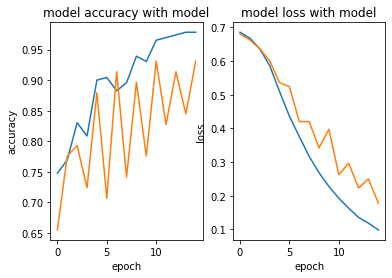

In [37]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history_final.history['accuracy'])
plt.plot(history_final.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history_final.history['loss'])
plt.plot(history_final.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Podemos observar como el accuracy de este modelo ha aumentado respecto de los otros dos realizados anteriormente. Para terminar veremos si aplicandole data augmentation se consigue una mejora relevante.
Sobre todo lo que queremos corregir con el data augmentation es el overfitting que se puede apreciar.

### 5.2. Con Data Augmentation

Por último desarrollaremos el modelo con dos categorias y aplicandole la técnica de data augmentation.

Volvemos a cargar los datos

In [44]:
orig_path = "drive/MyDrive/ICAI/Análisis de datos no estructurados/Practicas/Lenguaje de Signos/Data_Bi"
train_dir = os.path.join(orig_path, 'Train')
test_dir = os.path.join(orig_path, 'Test')

Primero aumentamos el dataset de train:

In [39]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [45]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(480,720),
        batch_size=8,
        class_mode='categorical')

Found 230 images belonging to 2 classes.


Ahora el de test. Nomrmalmente esta tecnica solo se hace para el train pero también lo vamos a hacer para el test ya que tenemos muy pocos datos

In [47]:
test_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [48]:
test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        target_size=(480,720),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 58 images belonging to 2 classes.


Ahora construimos el modelo Xception

In [49]:
tf_model = Xception(input_shape = (480, 720, 3),
                    include_top = False, weights = 'imagenet')

83697664/83683744 [==============================] - 1s 0us/step


En este punto decidimos descongelar alguna de las últimas capas.

In [50]:
unfreezed_convolutional_layers = 3
freezed_layers = tf_model.layers[:-unfreezed_convolutional_layers]

for layer in freezed_layers:
    layer.trainable = False

Añadimos una nueva capa densa, dropout y una última capa con 2 salidas

In [51]:
tf_model = keras.Sequential([
    tf_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(2, activation = 'softmax'),
])
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 15, 23, 2048)      20861480  
                                                                 
 flatten_1 (Flatten)         (None, 706560)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               90439808  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 111,301,546
Trainable params: 93,603,714
Non-trainable params: 17,697,832
_________________________________________________________________


In [52]:
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=2, 
    restore_best_weights=True,
)

In [54]:
history = tf_model.fit(
      train_generator,
      #steps_per_epoch=6, #100
      epochs=15, #100
      batch_size = 10,
      #callbacks=[early_stopping],
      validation_data=test_generator
      ) #50

Epoch 1/25
29/29 [==============================] - 41s 1s/step - loss: 12.7103 - accuracy: 0.8435 - val_loss: 0.5837 - val_accuracy: 0.9655
Epoch 2/25
29/29 [==============================] - 33s 1s/step - loss: 0.9327 - accuracy: 0.9652 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 3/25
29/29 [==============================] - 32s 1s/step - loss: 0.3213 - accuracy: 0.9913 - val_loss: 3.8410e-06 - val_accuracy: 1.0000
Epoch 4/25
29/29 [==============================] - 33s 1s/step - loss: 0.6958 - accuracy: 0.9696 - val_loss: 2.7004 - val_accuracy: 0.9138
Epoch 5/25
29/29 [==============================] - 32s 1s/step - loss: 0.6279 - accuracy: 0.9739 - val_loss: 12.0657 - val_accuracy: 0.9138
Epoch 6/25
29/29 [==============================] - 32s 1s/step - loss: 0.5635 - accuracy: 0.9913 - val_loss: 2.2648e-06 - val_accuracy: 1.0000
Epoch 7/25
29/29 [==============================] - 33s 1s/step - loss: 0.0365 - accuracy: 0.9957 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 

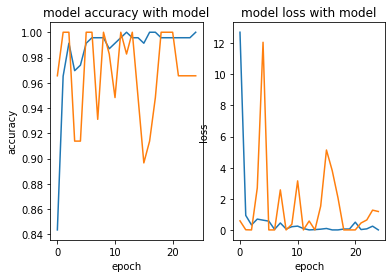

In [55]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Podemos observar que los resultados son casi perfectos. Tenemos un accurracy muy cercano a 1 y no se aprecia overfitting

### 5.3 Reintento datasets vocales

Viendo los buenos resultados que ha generado el modelo anterior, vamos a repetirlo para intentar clasificar las vocales

Volvemos a cargar los datasets

In [ ]:
base_dir = "drive/MyDrive/ICAI/Análisis de datos no estructurados/Sign_Language_Project/Data_Voc"
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

Generamos el data augmentation de nuevo

In [ ]:
train_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(480,720),
        batch_size=8,
        class_mode='categorical')

Found 346 images belonging to 5 classes.


In [ ]:
test_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=5,
      width_shift_range=0.3,
      height_shift_range=0.3,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [ ]:
test_generator = test_datagen.flow_from_directory(
        # This is the target directory
        test_dir,
        target_size=(480,720),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 88 images belonging to 5 classes.


Volvemos a utilizar la red Xception que nos ha dado tan buenos resultados

In [ ]:
tf_model = Xception(input_shape = (480, 720, 3),
                    include_top = False, weights = 'imagenet')

83697664/83683744 [==============================] - 1s 0us/step


En este punto decidimos descongelar alguna de las últimas capas. Para decidir qué número exacto descongelar, hicimos varias pruebas y los resultados nos indicaron que un número óptimo eran 6

In [ ]:
unfreezed_convolutional_layers = 6
freezed_layers = tf_model.layers[:-unfreezed_convolutional_layers]

for layer in freezed_layers:
    layer.trainable = False

Añadimos una nueva capa densa, dropout y una última capa con 2 salidas

In [ ]:
tf_model = keras.Sequential([
    tf_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(5, activation = 'softmax'),
])
tf_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 5)                 111303346 
                                                                 
 flatten_19 (Flatten)        (None, 5)                 0         
                                                                 
 dense_38 (Dense)            (None, 128)               768       
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 5)                 645       
                                                                 
Total params: 111,304,759
Trainable params: 95,192,079
Non-trainable params: 16,112,680
_________________________________________________________________


In [ ]:
tf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, 
    patience=2, 
    restore_best_weights=True,
)

In [ ]:
history = tf_model.fit(
      train_generator,
      #steps_per_epoch=6, #100
      epochs=25, #100
      batch_size = 10,
      #callbacks=[early_stopping],
      validation_data=test_generator
      ) #50

Epoch 1/25
44/44 [==============================] - 54s 1s/step - loss: 1.5097 - accuracy: 0.4277 - val_loss: 1.3921 - val_accuracy: 0.5909
Epoch 2/25
44/44 [==============================] - 49s 1s/step - loss: 1.2233 - accuracy: 0.6445 - val_loss: 1.1116 - val_accuracy: 0.6023
Epoch 3/25
44/44 [==============================] - 49s 1s/step - loss: 0.9800 - accuracy: 0.6965 - val_loss: 1.0718 - val_accuracy: 0.5909
Epoch 4/25
44/44 [==============================] - 49s 1s/step - loss: 0.8355 - accuracy: 0.7948 - val_loss: 0.7362 - val_accuracy: 0.8295
Epoch 5/25
44/44 [==============================] - 49s 1s/step - loss: 0.7198 - accuracy: 0.8121 - val_loss: 0.6666 - val_accuracy: 0.8295
Epoch 6/25
44/44 [==============================] - 49s 1s/step - loss: 0.6781 - accuracy: 0.8064 - val_loss: 0.7203 - val_accuracy: 0.7841
Epoch 7/25
44/44 [==============================] - 49s 1s/step - loss: 0.6295 - accuracy: 0.8121 - val_loss: 0.7817 - val_accuracy: 0.7159
Epoch 8/25
44/44 [==

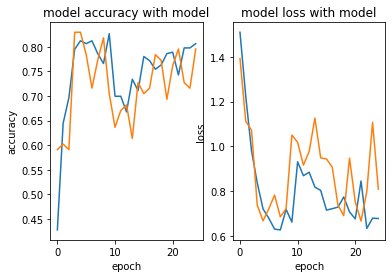

In [ ]:
f, axarr = plt.subplots(nrows=1,ncols=2)
plt.sca(axarr[0]); 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy with model')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend
plt.sca(axarr[1]); 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss with model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 6. Posibles Continuaciones

Como se puede ver en los resultados obtenidos a lo largo del notebook este problema parece ser un problema factible y "sencillo" en caso de disponer de la cantidad adeacuda de imagenes. Por ello algunas vias por las que se puede continuar son las siguientes:

    - Generación artificial de imagenes a traves de herramientas digitales.
    
    - Aumento del dataset a traves de imagenes propias.
    
    - Unión de varios datasets.
    
